# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [2]:
import pandas as pd 
df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [3]:
import pandas as pd 
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.lm import Vocabulary
from nltk.probability import FreqDist
from cleantext import clean
import concurrent.futures
import threading


def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
    # Flatten the list of tokens
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)
  return fq

In [4]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")

# make tokenize colum into a string with whitespace separator

After cleaning:
vocabulary size: 16577

After removing stopwords:
vocabulary size: 16445
reduction rate of the vocabulary size: 132 words

After stemming:
vocabulary size: 11031
reduction rate of the vocabulary size: 5414 words




1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [5]:
import pandas as pd 
# import dask.dataframe as dd

# df = pd.read_csv("995,000_rows.csv", usecols=['id','content', 'type', 'url', 'title', 'authors', 'domain'], engine='c', dtype = str)
# dfcpy = df.copy()
# dfcpy = dfcpy.dropna(subset=['id'])
# dfcpy = dfcpy.dropna(subset=['content'])
# dfcpy = dfcpy.dropna(subset=['type'])
# ddf = dd.from_pandas(dfcpy, npartitions=10) # find your own number of partitions

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  plt.yticks(range(0, max(all_freq.values())+1, 300))
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq1(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  plt.figure(figsize=(5, 16))
  plt.xticks(rotation=90,)
  sns.barplot(x = list(all_freq.values()), y = list(all_freq.keys()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Frequency')
  plt.ylabel('Words')
  plt.show()
  return

In [8]:
# ddf_update = ddf.content.apply(clean_text).compute()
dfcpy.content = dfcpy.content.apply(clean_text)

In [9]:
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)


In [11]:
dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)

In [13]:
dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)

In [ ]:
vocab = build_vocabulary(dfcpy.tokenized)

Number of URLs in the content: 243
Number of dates in the content: 103
Number of numerics in the content: 2194


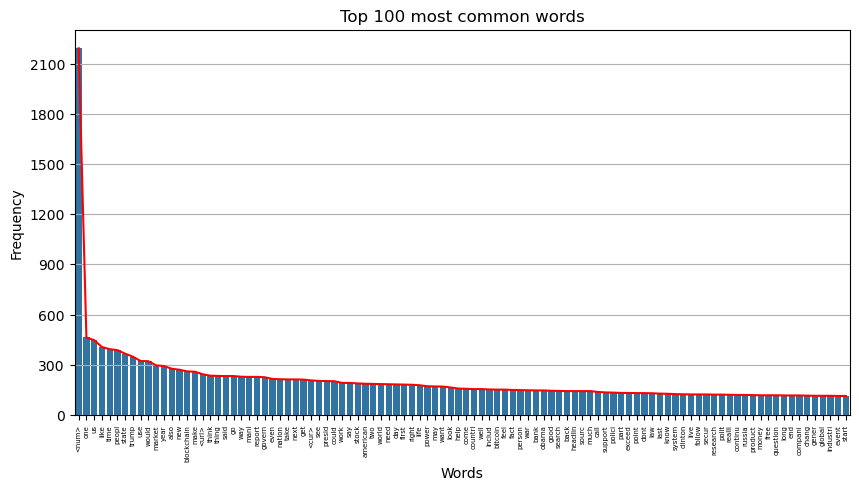

In [14]:
# make tokenize colum into a string with whitespace separator
dfcpy.tokenized = dfcpy.tokenized.apply(lambda x: ' '.join(x))
dfcpy.to_csv('cleaned_news_sample.csv', index=False)
url_freq = vocab.get("<url>",0)
date_freq = vocab.get("<date>",0)
num_freq = vocab.get("<num>",0)
print(f"Number of URLs in the content: {url_freq}")
print(f"Number of dates in the content: {date_freq}")
print(f"Number of numerics in the content: {num_freq}")
plot_freq(vocab, 100)


# Task 4

In [16]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_news_sample.csv')
dfcpy = df.copy()



dfcpy['fake'] = dfcpy['type'].map({'fake': 1, 'conspiracy': 1, 'junksci': 1, 'clickbait': 0, 'political': 0, 'reliable': 0})
dfcpy = dfcpy.dropna(subset=['fake'])
dfcpy['fake'] = dfcpy['fake'].astype(int)

X = dfcpy['tokenized']
y = dfcpy['fake']

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training Set:")
print(x_train.head())

print("\nValidation Set:")
print(x_val.head())

print("\nTest Set:")
print(x_test.head())




Training Set:
86     past <num> month other repeatedli warn isi pos...
175    trend global connect enterpri market <num> ana...
124    <num> principl govern success peopl headlin bi...
120    who poster talk headlin bitcoin blockchain sea...
110    son god goe forth war reader think stori fact ...
Name: tokenized, dtype: object

Validation Set:
166    fed seiz <cur> <num> million bitcoin alleg sil...
165    obama lawless presid us histori titl bush head...
131    easili understand differ day christ day lord e...
113    play hitler card headlin bitcoin blockchain se...
37     greg hunter big bank big troubl syrianorth kor...
Name: tokenized, dtype: object

Test Set:
149    hubbl captur incr rare imag explod star reader...
239    disturb sugar daddysugar babi relationship don...
160    worldwid laser technolog market analysi report...
89     interview princ harri septemb former presid ba...
80     richmond fed suffer biggest <num> month drop s...
Name: tokenized, dtype: object


# Part 2: A simple model

In [17]:
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics

# give each row a true/false column depending on if the type is fake or not using map


vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)
x_val_vectorized = vectorizer.transform(x_val)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(x_val_vectorized)
# score the model

accuracy_score = metrics.accuracy_score(y_val, y_pred)
recall_score = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
precision_score = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
f1_score = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

print(f"Accuracy: {accuracy_score}")
print(f"Recall: {recall_score}")
print(f"Precision: {precision_score}")  
print(f"F1: {f1_score}")

# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
print(confusion_matrix)

# classification report
classification_report = metrics.classification_report(y_val, y_pred, target_names = ['fake', 'real'], zero_division=0)
print(classification_report)


Accuracy: 0.8181818181818182
Recall: 1.0
Precision: 0.8181818181818182
F1: 0.9
[[18  0]
 [ 4  0]]
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00         4
        real       0.82      1.00      0.90        18

    accuracy                           0.82        22
   macro avg       0.41      0.50      0.45        22
weighted avg       0.67      0.82      0.74        22



# Part 3: Advanced model

Advanced:
- TF-IDF weights
- hyperparameters
- cross validation
- support vector machhine

After: 
- nerual network

In [21]:
from sklearn.model_selection import cross_validate
import sklearn.svm as svm
import sklearn.linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# make supoprt vector machine model using TF-IDF weighted word vectors, 
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)
x_val_vectorized = vectorizer.transform(x_val)
# create a pipeline

# parameters we want to test for the lm model
losses = list(['hinge', 'modified_huber', 'squared_hinge', 'perceptron'])
penalties = list(['l1', 'l2', 'elasticnet'])
alphas = list([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4,1e5])
l1_ratios = list([0.1, 0.3, 0.5, 0.7, 0.9])
param_grid_lm = dict(loss=losses,penalty=penalties, alpha=alphas, l1_ratio=l1_ratios)

# parameters we want to test for the liner SVC model
penalties = list(['l1', 'l2'])
losses = list(['hinge', 'squared_hinge'])
tol = list([1e-3, 1e-4, 1e-5, 1e-6])
C = list([0.1, 1, 10, 100, 1000])
param_grid_svm = dict(penalty=penalties, loss=losses, tol=tol, C=C)


model_sgdc = lm.SGDClassifier()
model_svm = svm.LinearSVC(dual=True)
model_sgdc.fit(X_train_vectorized, y_train)

# scaler = StandardScaler()
# model_svm = make_pipeline(scaler, model_svm)

# model_svm.fit(X_train_vectorized, y_train)


grid_lm = GridSearchCV(model_sgdc, param_grid_lm, cv=2, n_jobs=-1)
grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=2, n_jobs=-1, scoring='accuracy')

grid_lm.fit(X_train_vectorized, y_train)
grid_svm.fit(X_train_vectorized, y_train)

print(f"Best parameters for the linear model: {grid_lm.best_params_}")
print(f"Best parameters for the SVM model: {grid_svm.best_params_}")



Best parameters for the linear model: {'alpha': 1e-05, 'l1_ratio': 0.9, 'loss': 'hinge', 'penalty': 'l2'}
Best parameters for the SVM model: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.001}


/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitio